# Analysing Brooklyn's airbnb trends

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Importing and cleaning the data

[![png](images/nyc_airbnb.png)](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)

We'll use an open source dataset from Kaggle that contains New York's Airbnb data for 2019.

In [2]:
airbnb = pd.read_csv('airbnb.csv', usecols = ['neighbourhood','neighbourhood_group', 'reviews_per_month',
                                              'availability_365','price', 'room_type', 'last_review'])

display(airbnb.head(10))

,neighbourhood_group,neighbourhood,room_type,price,last_review,reviews_per_month,availability_365
0,Brooklyn,Kensington,Private room,149,2018-10-19,0.21,365
1,Manhattan,Midtown,Entire home/apt,225,2019-05-21,0.38,355
2,Manhattan,Harlem,Private room,150,NaN,NaN,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,2019-07-05,4.64,194
4,Manhattan,East Harlem,Entire home/apt,80,2018-11-19,0.10,0
5,Manhattan,Murray Hill,Entire home/apt,200,2019-06-22,0.59,129
6,Brooklyn,Bedford-Stuyvesant,Private room,60,2017-10-05,0.40,0
7,Manhattan,Hell's Kitchen,Private room,79,2019-06-24,3.47,220
8,Manhattan,Upper West Side,Private room,79,2017-07-21,0.99,0
9,Manhattan,Chinatown,Entire home/apt,150,2019-06-09,1.33,188


<br>Uppon a quick inspection of the dataset we can find several Nan values in different columns. NaNs tend to be a problem while handling datasets; let's see how widespread they are accross ours:

In [3]:
print(airbnb.isnull().sum())

neighbourhood_group        0
neighbourhood              0
room_type                  0
price                      0
last_review            10052
reviews_per_month      10052
availability_365           0
dtype: int64


<br>There are more than ten thousand NaN values in both the *last_review* column and the *reviews per moth* column. Let's find out how much that is compared to the total number of lines:

In [4]:
print('{:.2f} % NaN values'.format(airbnb.isnull().sum().reviews_per_month*100/len(airbnb)))

20.56 % NaN values


We have some ways of dealing with the NaN problem, just to name a few:
- Study where they are coming from; see if they are from a particular neighborhood or if they are split amongst all of them.
- Replace the NaN values with the mean value for that column for their neighborhood.
- Replace the NaN values with the global mean value for that column
- Discard the columns with the NaN values.
- Discard the rows with the NaN values.

Most of them would be time consuming, and dealing with NaNs is not the topic of this notebook. In this case, we'll just discard every row that has a NaN value:

In [5]:
airbnb.dropna(inplace=True)

<br>Another good practice is to look for duplicates:

In [6]:
print(airbnb.duplicated().sum())

9


We'll discard these rows:

In [7]:
airbnb.drop_duplicates(inplace = True)

<br>Now we'll lock for outliers in the data; values really out of place or just plainly wrong. This is easy to do through a boxplot:

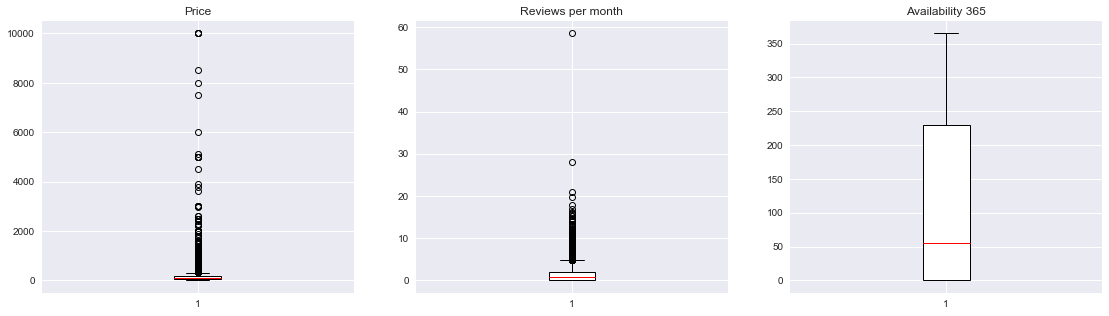

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
columns = ['price', 'reviews_per_month', 'availability_365']
for column, ax in zip(columns, axs):
    box = ax.boxplot(airbnb[column], patch_artist=True)
    ax.set_title(column.replace('_', ' ').capitalize())
    # styling
    plt.setp(box['boxes'], color='white')
    plt.setp(box['boxes'], edgecolor='black')
    plt.setp(box['medians'], color='red')
plt.show()

The *availability* column looks fine; the *price* one, even with its high prices, seems reasonable too (there are some really expensive apartments in NY); but if we take a closer look at the *reviews per month* column we'll be able to see how one apartment has almost 60 reviews per month. And unless that apartment is close to a black hole that distorts time making one day there two days in real life, months have 31 days at max.

*Note: Last time I checked, Airbnb reservations are made by one person only and you have to book the place for the night, hence the consideration of that value as an outlier.*

We'll get rid of that outlier:

In [9]:
airbnb = airbnb[airbnb.reviews_per_month <= 31]

<br>

### Williambsurg
Williamsburg is one of the trendiest neighborhoods nowadays. Since 2005 it has changed from an industrial district to a place that houses many young people and blooming businesses. We'll analyse how it does on Airbnb compared with the rest of the neighborhoods; for that, we'll take into account the *availability* and the *reviews per month*, which intuitively will let us know how solicited different neighborhoods are and how people rate them.

First, we'll categorise the listings by the ammount of reviews per month (rpm) they get. We'll split them into three categories:
- Low ammount of rpm.
- Medium ammount of rpm.
- High ammount of rpm.

In [10]:
# We create a new column to store the tag 
airbnb['reviews_tag'] = ''

# And divide the data using quantiles
quantiles = airbnb['reviews_per_month'].quantile([0.33, 0.66])

airbnb.loc[(airbnb.reviews_per_month > 0 ) & (airbnb.reviews_per_month <= quantiles.values[0]), 'reviews_tag'] = 'Low'
airbnb.loc[(airbnb.reviews_per_month > quantiles.values[0] ) & (airbnb.reviews_per_month <= quantiles.values[1]), 'reviews_tag'] = 'Medium'
airbnb.loc[(airbnb.reviews_per_month > quantiles.values[1] ), 'reviews_tag'] = 'High'

<br>Now we'll classify the listings based on their availability in a similar manner; we'll use the following tags:
- Low demand
- Average demand
- High demand

In [11]:
airbnb['availability_tag'] = ''

quantiles = airbnb['availability_365'].quantile([0.33, 0.66])

airbnb.loc[(airbnb.availability_365 <= quantiles.values[0]), 'availability_tag'] = 'High demand'
airbnb.loc[(airbnb.availability_365 > quantiles.values[0] ) & (airbnb.availability_365 <= quantiles.values[1]), 'availability_tag'] = 'Average demand'
airbnb.loc[(airbnb.availability_365 > quantiles.values[1] ), 'availability_tag'] = 'Low demand'

<br>Lastly, we'll relate the number of reviews with the availability to obtain a rating for the listing; if it's on high demand and it gets plenty of reviews, it's safe to assume its a very good place. On the oder hand, if it has low demand and has a high number of reviews per month, the place is probably not the best.

We'll use the following tags:
- Very good
- Good
- Average
- Bad
- Very bad

In [12]:
airbnb['classification'] = ''
classification_tags = ['Very good', 'Good', 'Average', 'Bad', 'Very bad']

airbnb.loc[(airbnb['reviews_tag'] == 'Low') & (airbnb['availability_tag'] == 'High demand'), 'classification'] = 'Good'
airbnb.loc[(airbnb['reviews_tag'] == 'Medium') & (airbnb['availability_tag'] == 'High demand'), 'classification'] = 'Good'
airbnb.loc[(airbnb['reviews_tag'] == 'High') & (airbnb['availability_tag'] == 'High demand'), 'classification'] = 'Very good'

airbnb.loc[(airbnb['reviews_tag'] == 'Low') & (airbnb['availability_tag'] == 'Average demand'), 'classification'] = 'Average'
airbnb.loc[(airbnb['reviews_tag'] == 'Medium') & (airbnb['availability_tag'] == 'Average demand'), 'classification'] = 'Average'
airbnb.loc[(airbnb['reviews_tag'] == 'High') & (airbnb['availability_tag'] == 'Average demand'), 'classification'] = 'Good'

airbnb.loc[(airbnb['reviews_tag'] == 'Low') & (airbnb['availability_tag'] == 'Low demand'), 'classification'] = 'Bad'
airbnb.loc[(airbnb['reviews_tag'] == 'Medium') & (airbnb['availability_tag'] == 'Low demand'), 'classification'] = 'Bad'
airbnb.loc[(airbnb['reviews_tag'] == 'High') & (airbnb['availability_tag'] == 'Low demand'), 'classification'] = 'Very bad'

<br>Let's see the changes:

In [13]:
display(airbnb.head())

,neighbourhood_group,neighbourhood,room_type,price,last_review,reviews_per_month,availability_365,reviews_tag,availability_tag,classification
0,Brooklyn,Kensington,Private room,149,2018-10-19,0.21,365,Low,Low demand,Bad
1,Manhattan,Midtown,Entire home/apt,225,2019-05-21,0.38,355,Medium,Low demand,Bad
3,Brooklyn,Clinton Hill,Entire home/apt,89,2019-07-05,4.64,194,High,Low demand,Very bad
4,Manhattan,East Harlem,Entire home/apt,80,2018-11-19,0.10,0,Low,High demand,Good
5,Manhattan,Murray Hill,Entire home/apt,200,2019-06-22,0.59,129,Medium,Average demand,Average


<br>Let's take a look at the top 10 neighborhoods in Brooklyn so we can see how Williamsburg compares:

In [14]:
brooklyn = airbnb.loc[airbnb.neighbourhood_group == 'Brooklyn', :]

top_10 = brooklyn['neighbourhood'].value_counts()[:10]

# Neighborhood names
top_10_names = top_10.index

# Their review count
top_10_nreviews = top_10.values

# This piece of code gets the number of reviews and puts them in a list for a later use in a graph
scores = []
for neighborhood in top_10_names:
    # For each neighborhood in the top 10, we get the ammount of classifications of each type
    reviews = airbnb.loc[airbnb.neighbourhood == neighborhood, 'classification'].value_counts().reindex(classification_tags).values
    scores.append(reviews)
scores = np.array(scores)

# Normalized scores 
scores_norm = scores * 100 / scores.sum(axis=1)[:, None]

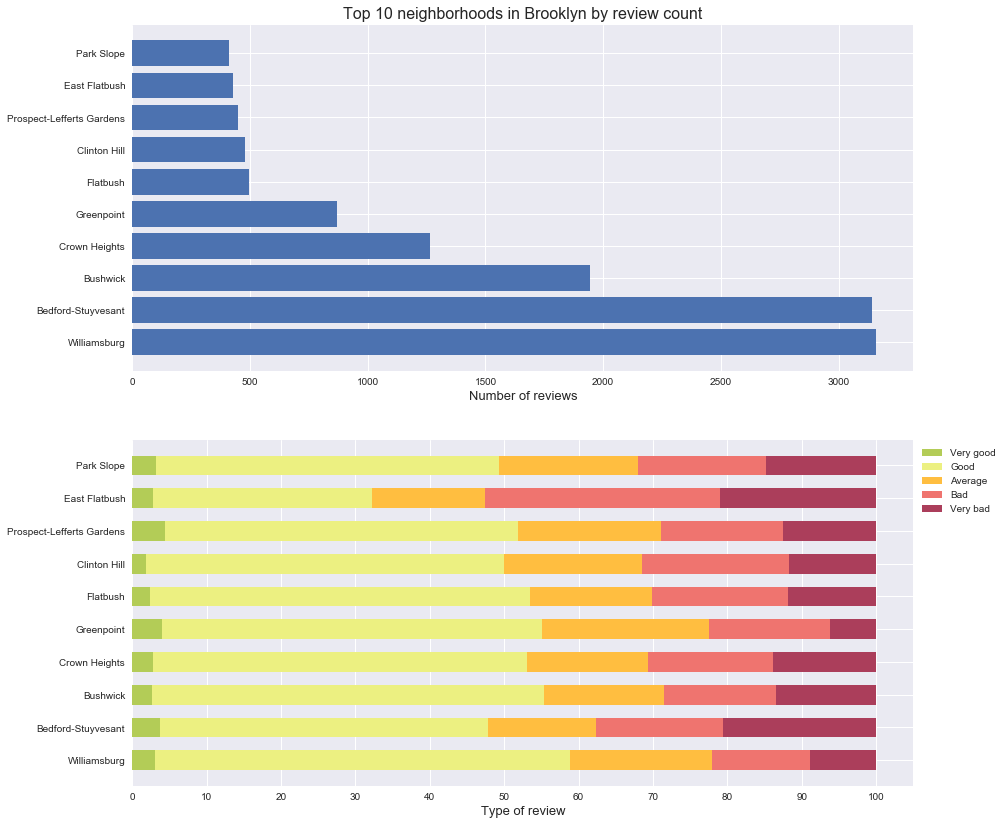

In [15]:
fig, ax = plt.subplots(2,1, figsize = (14,14))

# Number of reviews
ax[0].barh(top_10_names, top_10_nreviews)
ax[0].set_xlabel('Number of reviews', fontsize = 13)
ax[0].set_title('Top 10 neighborhoods in Brooklyn by review count', fontsize = 16)

# Type of reviews
scores_norm_cum = scores_norm.cumsum(axis=1)
colors = ['#B3CC57','#ECF081', '#FFBE40', '#EF746F', '#AB3E5B']
for i, (reviews, color) in enumerate(zip(scores, colors)):
    if i<5:
        widths = scores_norm[:,i]
        starts = scores_norm_cum[:,i] - widths
        ax[1].barh(top_10_names, widths, left = starts, height = 0.6, color = color)

ax[1].legend(classification_tags,
             loc = 'best', bbox_to_anchor = (1,1))
ax[1].set_xlabel('Type of review', fontsize = 13)
ax[1].set_xticks(np.arange(0,110,10))
plt.show()

These two plots show the busiest neighborhoods in Brooklyn based on the number of reviews. You can appreciate how Williamsburg is the neighborhood with the highnest number of reviews, closely follow by Bedford-Stuyvesant.

Even though these two neighborhoods have a similar ammount of reviews, if we take a look at the second plot we are able to see that Bedford has close to 20% more negative reviews than Williamsburg; the former has close to 40% negative reviews while the latter close to 20%.

There are two interesting neighborhoods based on the second plot: Williamsburg, for having the highest number of reviews and the highest proportion of possitive reviews, and East Flatbush, where the number of negative reviews is higher than that of the possitive reviews and the neutral reviews added.

<br>

### Taking a look at the Top 5

We'll now group the different neighborhoods by *classification*, keeping the 5 with the highest proportion of *Very good* reviews:

In [16]:
airbnb.head()

,neighbourhood_group,neighbourhood,room_type,price,last_review,reviews_per_month,availability_365,reviews_tag,availability_tag,classification
0,Brooklyn,Kensington,Private room,149,2018-10-19,0.21,365,Low,Low demand,Bad
1,Manhattan,Midtown,Entire home/apt,225,2019-05-21,0.38,355,Medium,Low demand,Bad
3,Brooklyn,Clinton Hill,Entire home/apt,89,2019-07-05,4.64,194,High,Low demand,Very bad
4,Manhattan,East Harlem,Entire home/apt,80,2018-11-19,0.10,0,Low,High demand,Good
5,Manhattan,Murray Hill,Entire home/apt,200,2019-06-22,0.59,129,Medium,Average demand,Average


In [17]:
neighborhood_data = airbnb.groupby('neighbourhood')['classification'].value_counts().unstack().fillna(0)

top_5 = neighborhood_data.sort_values(by='Very good', ascending = False)[:5]
top_5 = top_5[classification_tags]

<br>Let's now add the relevant information to each neighborhood (average price, monthly reviews and availability):

In [18]:
top_5_data = airbnb.groupby(['neighbourhood', 'classification']).mean()
top_5_data = top_5_data.loc[list(top_5.index),:]
display(top_5_data)

price  reviews_per_month  \
neighbourhood      classification                                  
Bedford-Stuyvesant Average         109.784615           0.643934   
                   Bad             118.788889           0.610815   
                   Good             97.705202           1.440918   
                   Very bad        114.758140           3.001256   
                   Very good        80.991453           2.749145   
East Harlem        Average         119.462585           0.701633   
                   Bad             138.109489           0.634088   
                   Good            135.644540           1.706510   
                   Very bad        143.063830           2.990071   
                   Very good       102.288462           3.279038   
Harlem             Average         140.229167           0.636589   
                   Bad             134.755396           0.543285   
                   Good             99.512974           1.328054   
                   Very bad        127.177019           2.934534   
                   Very good        93.888889           2.587654   
Upper West Side    Average         202.295276           0.559764   
                   Bad             256.527157           0.427572   
                   Good            155.208895           0.933518   
                   Very bad        193.975410           3.148197   
                   Very good       118.705882           2.637451   
Williamsburg       Average         152.343907           0.623573   
                   Bad             163.973558           0.540601   
                   Good            123.576531           1.002177   
                   Very bad        185.812721           3.090883   
                   Very good       122.278351           2.419485   

                                   availability_365  
neighbourhood      classification                    
Bedford-Stuyvesant Average                54.663736  
                   Bad                   286.438889  
                   Good                   25.439306  
                   Very bad              270.220155  
                   Very good               0.102564  
East Harlem        Average                55.795918  
                   Bad                   273.131387  
                   Good                   27.569593  
                   Very bad              258.163121  
                   Very good               0.134615  
Harlem             Average                60.968750  
                   Bad                   282.633094  
                   Good                   21.726547  
                   Very bad              255.701863  
                   Very good               0.148148  
Upper West Side    Average                55.169291  
                   Bad                   281.929712  
                   Good                   13.057951  
                   Very bad              261.901639  
                   Very good               0.137255  
Williamsburg       Average                49.784641  
                   Bad                   275.733173  
                   Good                   16.390590  
                   Very bad              270.038869  
                   Very good               0.082474

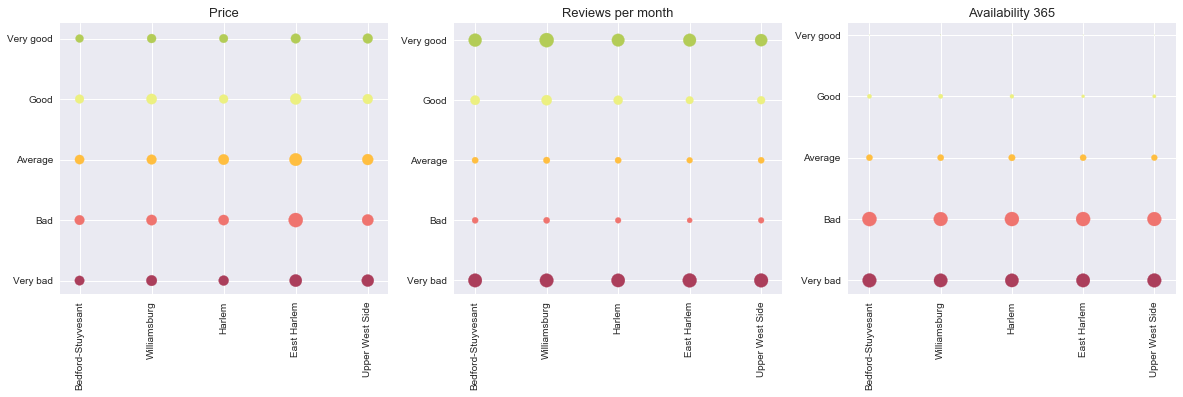

In [19]:
plot_reviews = list(top_5.columns)[::-1]

colors = ['#B3CC57','#ECF081', '#FFBE40', '#EF746F', '#AB3E5B']
plots = ['price', 'reviews_per_month', 'availability_365']
colors = colors[::-1]

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, plot in enumerate(plots):

    
    sizes = []
    for review in plot_reviews:
        sizes.append(top_5_data.xs(review, level='classification', drop_level = False)[plot].values)
    
    # up-scaling for a better view
    sizes = np.array(sizes)
    sizes = (200 * sizes) / sizes.max()
        
    for j, (size, color) in enumerate(zip(sizes, colors)):
        x = np.arange(0, len(size), 1)
        y = np.full(len(sizes), j)
        ax[i].scatter(x, y, size, c = color)

    ax[i].set_yticks(np.arange(5))
    ax[i].set_xticks(np.arange(5))
    ax[i].set_xticklabels(top_5.index, rotation = 'vertical')
    ax[i].set_yticklabels(plot_reviews)

    ax[i].set_title(plot.replace('_', ' ').capitalize(), fontsize = 13)
    
plt.show()

From left to right, these plots show the correlation between price, monthly reviews and availiability with the neighborhood and the rating for the neighborhood, where the size of the bubble meaning higher or lower price, number of reviews or availability, and the color being associated with the type of review (green for very good, yellow for good, etc.).

Starting with the plot on the left, we can say that the price difference between the highest and the lowest rated places is not that high, although we can see how higher rated places tend to be cheaper than lower rated ones. It's pretty likely that places reviewed as *Very bad* were expensive and failed to meet the associated expectations in quality, hence the review. On the other hand, those with the best score have lower places, which can indicate that they probably satisfied the expectations for a lower priced place.

The plot in the middle shows some horizontal symmetry; it looks like the users are more likely to voice their opinions when the place has left a strong impression in them, either a really good or a really bad one. Users tend to speak up to recommend places they have enjoyed and discourage others from staying at places where they've had a bad time. On the other hand, places reviewed from *Good* to *Average* show a smaller number of reviews, which supports the strong impression hypothesis.

Finally, the plot in the right shows a really strong, easy to interpret gradient; the quality of the place is closely related to its availability. We can (barely) see how the best rated places are rarely available, while the opposite is true for the worst rated ones.

<br>

### What to rent? Comparing prices

Now that we now where to rent (and where not to), let's try to understand the differences between renting an apartment, a shared room and a private room:

In [20]:
top_5_data = airbnb.groupby(['neighbourhood', 'room_type']).mean()
top_5_data = top_5_data.loc[list(top_5.index),:]
top_5_data.reset_index(inplace=True)

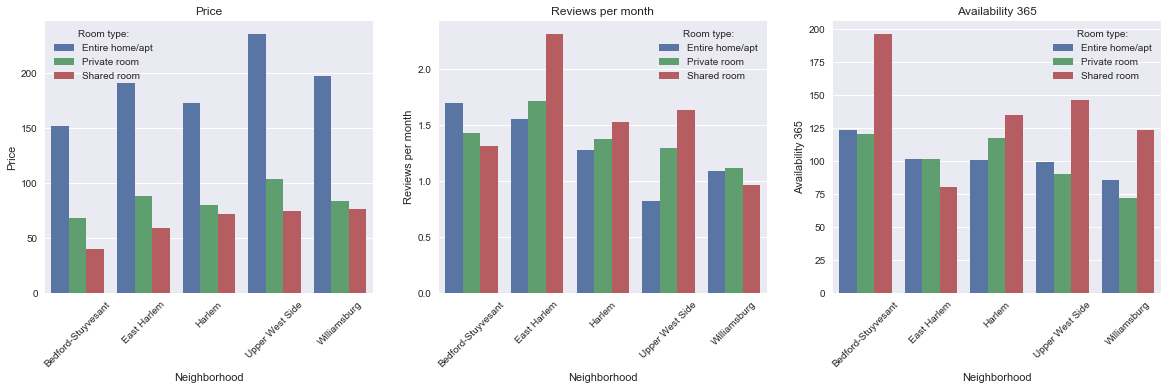

In [21]:
fig, axs = plt.subplots(1,3, figsize=(20,5))

columns = ['price', 'reviews_per_month', 'availability_365']
for ax, column in zip(axs, columns):
    sns_plot = sns.barplot(x='neighbourhood', y=column, hue='room_type', data=top_5_data, ax=ax)
    # styling
    sns_plot.set_title(column.replace('_', ' ').capitalize())
    sns_plot.set_ylabel(column.replace('_', ' ').capitalize())
    sns_plot.set_xlabel('Neighborhood')
    sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=45)
    sns_plot.legend(title='Room type:')
    
plt.show()

In the first plot we are able to see how it's way more expensive (almost double the price in most cases) to rent an entire home/apt than renting a private or a share room, with the last one being the cheapest option.

The fact that renting an entire home/apt is the most expensive option doesn't prevent it from being the prefered one; if we take a look at the third plot, renting the whole apt is the prefered option together with renting a private room; it's safe to say that users value their privacy and will pay additional money to keep it.